In [84]:
import json
import heapq

import numpy as np
import matplotlib.pyplot as plt
import nlgeval

In [112]:
NLGEVAL = nlgeval.NLGEval(no_skipthoughts=True, no_glove=True)

In [73]:
def get_min_max_candidates(in_predictions, in_distances, top_n=10):
    min_distance, max_distance = np.inf, -np.inf
    min_distance_heap, max_distance_heap = ([(-np.inf, None) for _ in range(top_n)],
                                            [(-np.inf, None) for _ in range(top_n)])

    for pred, distance in zip(in_predictions, in_distances):
        if distance is None:
            continue
        heapq.heapreplace(min_distance_heap, (-distance, json.dumps(pred)))
        heapq.heapreplace(max_distance_heap, (distance, json.dumps(pred)))
    return {'min': [(-distance, json.loads(pred)) for distance, pred in min_distance_heap][::-1],
            'max': [(distance, json.loads(pred)) for distance, pred in max_distance_heap][::-1]}

In [66]:
def get_candidate_distances(in_predictions):
    distances = []
    for pred in in_predictions:
        scores = list(map(lambda x: x['score'], pred['candidates']))
        if not len(scores):
            distance = None
        else:
            min_score, max_score = min(scores), max(scores)
            distance = abs(max_score - min_score)
        distances.append(distance)
    return distances

In [15]:
def print_prediction(in_prediction):
    print('ID: ', in_prediction['id'])
    print('INPUT:')
    for turn in in_prediction['input']:
        print('{}: {}'.format(turn['side'], turn['utterance']))
    print('TARGET:')
    print(in_prediction['target'])
    print('CANDIDATES:')
    for cand_turn in in_prediction['candidates']:
        print('{} [{}] [{}]'.format(cand_turn['utterance'], cand_turn['score'], cand_turn['method']))

In [4]:
LOG_FILES = ['metalwoz_pure_ext_info_parsed.json', 'metalwoz_pure_ext_info_parsed.json', 'multiwoz_ext_info_parsed.json']

In [45]:
logs = []
for log_file in LOG_FILES:
    with open(log_file) as log_in:
        logs.append(json.load(log_in))

# MetaLWOz pure task

In [93]:
log = logs[0]
distances = get_candidate_distances(log)
min_max_preds = get_min_max_candidates(log, distances)

### Predictions with 10 closest retrieved/generated pairs

In [75]:
min_preds = min_max_preds['min']
for _, pred in min_preds:
    print_prediction(pred)
    print('')

ID:  da417c64
INPUT:
Wizard: Hello how may I help you?
User: What to do in Miami?
Wizard: There are many fun things to in Miami. Are you looking for leisure or exciting activities?
User: Both.
Wizard: You can try parasailing or riding Jet Skis in Miami Beach. There are also snorkeling tours in Key West. Do
User: Great. Added those on my list already.
Wizard: You can also try visiting the Frost Art Museum in Miami. Hope this helps.
User: Okay
Wizard: Can I help you with anything else today?
TARGET:
Thats all.
CANDIDATES:
No thanks [1.831] [retrieved]
No thanks [1.831] [generated]

ID:  bfebee55
INPUT:
Wizard: Hello how may I help you?
User: Yes I need to book a flight ASAP
Wizard: to where?
TARGET:
I need to be in Europe by a certain date
CANDIDATES:
Europe [2.513] [retrieved]
Europe [2.513] [generated]

ID:  e8264eb8
INPUT:
Wizard: Hello how may I help you?
User: Hi I need to book a flight to Hawaii for two
Wizard: When do you want to go?
User: June 10th Is a great day
Wizard: I have t

### Prediction with the most distant retrieved and generated scores

In [57]:
max_preds = min_max_preds['max']
for _, pred in max_preds:
    print_prediction(pred)
    print('')

ID:  1b09f1b2
INPUT:
Wizard: Hello how may I help you?
User: I need some vacation help.
Wizard: Tell me more of what you would like to know about vacations?
TARGET:
I need a place that would be good to bring kids to.
CANDIDATES:
I want to spend a weekend with my kids. I don't want to spend too much time with [-0.471] [generated]
Where's a good place to bring some kids? [-0.583] [retrieved]

ID:  c8322f9b
INPUT:
Wizard: Hello how may I help you?
User: hello, I need tourism advise
Wizard: I can set you up.
User: what is the best time to visit cyptus? cyprus
Wizard: Early summer is the best if you ask me.
User: ok thank you.
Wizard: Right now is a really good time. Do you have time off soon?
User: yes, i am planning to go there at summer.
Wizard: How many vacation days have you got piled up?
TARGET:
2 weeks. thank you.
CANDIDATES:
i only have vacation days, i need to look forward to the trip. [3.723] [generated]
thank you for your help [-8.222] [retrieved]

ID:  174602b7
INPUT:
Wizard: He

### Histogram of distances between the gen/ret candidates' scores

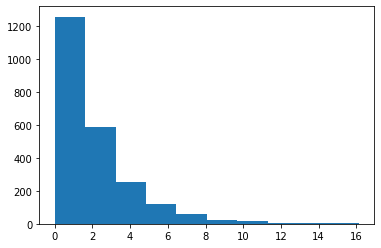

In [76]:
plt.hist(distances, bins=10)
plt.show()

### Histogram of distances - zero/non-zero

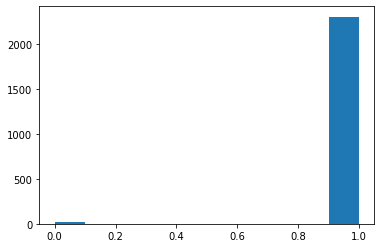

In [78]:
plt.hist([int(distance != 0.0) for distance in distances], bins=10)
plt.show()

### NLG-Eval metrics between ground truth targets and generated/retrieved responses

In [108]:
targets, gen_candidates, ret_candidates = [], [], []
for prediction in log:
    candidates = prediction['candidates']
    gen_candidates_i = [candidate['utterance'] for candidate in candidates
                        if candidate['method'] == 'generated']
    ret_candidates_i = [candidate['utterance'] for candidate in candidates
                        if candidate['method'] == 'retrieved']
    if not len(ret_candidates_i) or not len(gen_candidates_i):
        continue
    targets.append(prediction['target'])
    gen_candidates.append(gen_candidates_i[0])
    ret_candidates.append(ret_candidates_i[0])

In [116]:
NLGEVAL.compute_metrics([targets], gen_candidates)

{'Bleu_1': 0.13775401958052755,
 'Bleu_2': 0.08709841483809297,
 'Bleu_3': 0.06053476737727977,
 'Bleu_4': 0.043493544949373394,
 'METEOR': 0.09700586169517364,
 'ROUGE_L': 0.1249785288608312,
 'CIDEr': 0.339336160363538}

In [117]:
NLGEVAL.compute_metrics([targets], ret_candidates)

{'Bleu_1': 0.13134569376126987,
 'Bleu_2': 0.08049205082782263,
 'Bleu_3': 0.05600173107632877,
 'Bleu_4': 0.041217311572226585,
 'METEOR': 0.09318854214218383,
 'ROUGE_L': 0.10631682326911585,
 'CIDEr': 0.2712611723902696}

# MetaLWOz cross task

In [118]:
log = logs[1]
distances = get_candidate_distances(log)
min_max_preds = get_min_max_candidates(log, distances)

### Predictions with 10 closest retrieved/generated pairs

In [119]:
min_preds = min_max_preds['min']
for _, pred in min_preds:
    print_prediction(pred)
    print('')

ID:  da417c64
INPUT:
Wizard: Hello how may I help you?
User: What to do in Miami?
Wizard: There are many fun things to in Miami. Are you looking for leisure or exciting activities?
User: Both.
Wizard: You can try parasailing or riding Jet Skis in Miami Beach. There are also snorkeling tours in Key West. Do
User: Great. Added those on my list already.
Wizard: You can also try visiting the Frost Art Museum in Miami. Hope this helps.
User: Okay
Wizard: Can I help you with anything else today?
TARGET:
Thats all.
CANDIDATES:
No thanks [1.831] [retrieved]
No thanks [1.831] [generated]

ID:  bfebee55
INPUT:
Wizard: Hello how may I help you?
User: Yes I need to book a flight ASAP
Wizard: to where?
TARGET:
I need to be in Europe by a certain date
CANDIDATES:
Europe [2.513] [retrieved]
Europe [2.513] [generated]

ID:  e8264eb8
INPUT:
Wizard: Hello how may I help you?
User: Hi I need to book a flight to Hawaii for two
Wizard: When do you want to go?
User: June 10th Is a great day
Wizard: I have t

### Prediction with the most distant retrieved and generated scores

In [120]:
max_preds = min_max_preds['max']
for _, pred in max_preds:
    print_prediction(pred)
    print('')

ID:  c9595979
INPUT:
Wizard: Hello how may I help you?
User: I need some tourism help.
Wizard: where would you like to travel to?
User: Montreal. I''m going there this summer. Where are some good spots to go?
Wizard: it depends on how much your are willing ti spent.
User: Well, I'm looking for some festivals in the area around that time. Can you just give me some suggestions?
Wizard: what is your budget?
TARGET:
Budget doesn't matter. I just want to know where I can go.
CANDIDATES:
My budget is $15.00 per ticket. [2.109] [generated]
Great! Thanks so muvh [-14.034] [retrieved]

ID:  7596b1d7
INPUT:
Wizard: Hello how may I help you?
User: Hello. I need to book a flight for two
Wizard: ok where are you going?
User: I will be heading to Hawaii and I need to leave tonight
Wizard: will you be bringing extra luggage?
User: No, I will need first class seats. Money is no object
Wizard: i have 2 tickets for $50,000
User: Okay, that will be fine. Please purchase with my credit card on file
Wizard

### Histogram of distances between the gen/ret candidates' scores

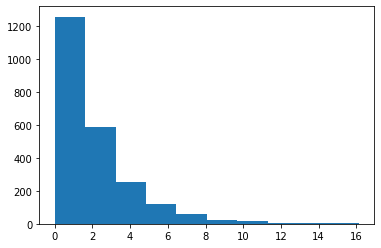

In [121]:
plt.hist(distances, bins=10)
plt.show()

### Histogram of distances - zero/non-zero

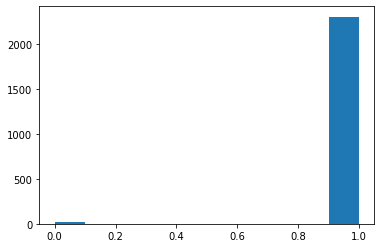

In [122]:
plt.hist([int(distance != 0.0) for distance in distances], bins=10)
plt.show()

### NLG-Eval metrics between ground truth targets and generated/retrieved responses

In [123]:
targets, gen_candidates, ret_candidates = [], [], []
for prediction in log:
    candidates = prediction['candidates']
    gen_candidates_i = [candidate['utterance'] for candidate in candidates
                        if candidate['method'] == 'generated']
    ret_candidates_i = [candidate['utterance'] for candidate in candidates
                        if candidate['method'] == 'retrieved']
    if not len(ret_candidates_i) or not len(gen_candidates_i):
        continue
    targets.append(prediction['target'])
    gen_candidates.append(gen_candidates_i[0])
    ret_candidates.append(ret_candidates_i[0])

In [124]:
NLGEVAL.compute_metrics([targets], gen_candidates)

{'Bleu_1': 0.13775401958052755,
 'Bleu_2': 0.08709841483809297,
 'Bleu_3': 0.06053476737727977,
 'Bleu_4': 0.043493544949373394,
 'METEOR': 0.09700586169517364,
 'ROUGE_L': 0.1249785288608312,
 'CIDEr': 0.339336160363538}

In [125]:
NLGEVAL.compute_metrics([targets], ret_candidates)

{'Bleu_1': 0.13134569376126987,
 'Bleu_2': 0.08049205082782263,
 'Bleu_3': 0.05600173107632877,
 'Bleu_4': 0.041217311572226585,
 'METEOR': 0.09318854214218383,
 'ROUGE_L': 0.10631682326911585,
 'CIDEr': 0.2712611723902696}

# MultiWoz

In [126]:
log = logs[2]
distances = get_candidate_distances(log)
min_max_preds = get_min_max_candidates(log, distances)

### Predictions with 10 closest retrieved/generated pairs

In [127]:
min_preds = min_max_preds['min']
for _, pred in min_preds:
    print_prediction(pred)
    print('')

ID:  SSNG0390
INPUT:
Wizard: Hello, how may I help you?
User: Can you find me a hotel in the moderate price range?
Wizard: There are 18 hotels in the moderate price range. Are you looking for free parking or free wifi?
User: I don't need internet. Are any of them 3 stars?
Wizard: No none of them are 3 stars or 4 stars, I have a few that are 2 stars would they be okay?
User: If that's all that is available that's fine, I need it for 1 person for 3 nights starting Thursday, please
Wizard: Great! I have booked you at Lovell Lodge with reference number 6YI7ENAC. May I help with anything else?
User: No that is all I need. Thanks for your help.
Wizard: Have a good day. Thank you for using our service.
TARGET:
Thank you! Have a great day!
CANDIDATES:
Thanks again for your help. [3.282] [retrieved]
Thanks again! [3.282] [generated]

ID:  SSNG0151
INPUT:
Wizard: Hello, how may I help you?
User: I am looking for a place to dine located in the centre and in the moderate price range. Can you help 

### Prediction with the most distant retrieved and generated scores

In [128]:
max_preds = min_max_preds['max']
for _, pred in max_preds:
    print_prediction(pred)
    print('')

ID:  SNG1313
INPUT:
Wizard: Hello, how may I help you?
User: i am looking for a train. The train should leave on Monday and should arrive by 12:45.
Wizard: Where would you like to go?
TARGET:
I would like to depart from Cambridge, and travel to Bishops Stortford.
CANDIDATES:
i would like to go to Cambridge. [5.253] [generated]
I would like to leave after 09:00 on Sunday. [-11.019] [retrieved]

ID:  SNG0481
INPUT:
Wizard: Hello, how may I help you?
User: Hi, I'm looking for an Indian restaurant. I 'd prefer something on the west side.
Wizard: I have found 6 restaurants meeting your criteria. Rice boat is a good choice. Would you like me to book you a
User: I'm looking for something in the fine dining price range, so the place should be expensive. Are there any
Wizard: Absolutely, there are a few choices. How about Tandoori Palace on Histon Road?
TARGET:
That sounds good. may I have their postcode, address, and phone number?
CANDIDATES:
Tandoori Palace sounds good, how about another rest

### Histogram of distances between the gen/ret candidates' scores

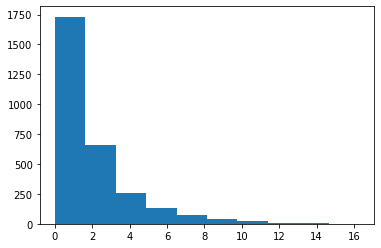

In [130]:
plt.hist([dist for dist in distances if dist is not None], bins=10)
plt.show()

### Histogram of distances - zero/non-zero

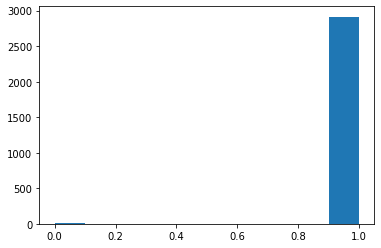

In [131]:
plt.hist([int(distance != 0.0) for distance in distances if distance is not None], bins=10)
plt.show()

### NLG-Eval metrics between ground truth targets and generated/retrieved responses

In [132]:
targets, gen_candidates, ret_candidates = [], [], []
for prediction in log:
    candidates = prediction['candidates']
    gen_candidates_i = [candidate['utterance'] for candidate in candidates
                        if candidate['method'] == 'generated']
    ret_candidates_i = [candidate['utterance'] for candidate in candidates
                        if candidate['method'] == 'retrieved']
    if not len(ret_candidates_i) or not len(gen_candidates_i):
        continue
    targets.append(prediction['target'])
    gen_candidates.append(gen_candidates_i[0])
    ret_candidates.append(ret_candidates_i[0])

In [133]:
NLGEVAL.compute_metrics([targets], gen_candidates)

{'Bleu_1': 0.14955109483649628,
 'Bleu_2': 0.08277910458148781,
 'Bleu_3': 0.05136282278236329,
 'Bleu_4': 0.03196999204230297,
 'METEOR': 0.10814399980936394,
 'ROUGE_L': 0.15344245543239704,
 'CIDEr': 0.2639145591876558}

In [134]:
NLGEVAL.compute_metrics([targets], ret_candidates)

{'Bleu_1': 0.16155129289626197,
 'Bleu_2': 0.0891345862870597,
 'Bleu_3': 0.05578943546678236,
 'Bleu_4': 0.03536344030926011,
 'METEOR': 0.11407574794797835,
 'ROUGE_L': 0.15155906418256765,
 'CIDEr': 0.2824172075692828}